In [153]:
import numpy as np
import pandas as pd
import math
from tqdm import tqdm
from pathlib import Path

def generate_virtual_crystal_lut_from_opengate_sim_with_gaps(
    sim,
    output_path: str,
    virtual_size_radial_mm: float,
    virtual_size_tangential_mm: float,
    virtual_size_axial_mm: float,
    crystal_center_r_mm: float,
    start_angle_deg: float = 190.0,
    gap_stack_tangential_mm: float = 0.25,
    gap_stack_axial_mm: float = 0.25,
    dry_run: bool = False
):
    # Read actual crystal geometry from sim
    cry_vol = sim.volume_manager.volumes["pet_crystal"]
    crystal_size_radial_mm = cry_vol.size[0]
    crystal_size_tangential_mm = cry_vol.size[1]
    crystal_size_axial_mm = cry_vol.size[2]

    # Geometry layout
    n_modules = 18
    n_stacks_tangential = 4
    n_stacks_axial = 5
    n_die_tangential = 4
    n_die_axial = 4
    n_crystals_per_die_tangential = 2
    n_crystals_per_die_axial = 2

    n_crystals_radial = 1
    n_crystals_per_stack_tangential = n_die_tangential * n_crystals_per_die_tangential
    n_crystals_per_stack_axial = n_die_axial * n_crystals_per_die_axial
    n_crystals_tangential = n_modules * n_stacks_tangential * n_crystals_per_stack_tangential
    n_crystals_axial = n_stacks_axial * n_crystals_per_stack_axial

    # Virtual crystal splitting
    assert crystal_size_radial_mm % virtual_size_radial_mm == 0
    assert crystal_size_tangential_mm % virtual_size_tangential_mm == 0
    assert crystal_size_axial_mm % virtual_size_axial_mm == 0

    n_virtual_radial = int(crystal_size_radial_mm / virtual_size_radial_mm)
    n_virtual_tangential = int(crystal_size_tangential_mm / virtual_size_tangential_mm)
    n_virtual_axial = int(crystal_size_axial_mm / virtual_size_axial_mm)

    n_radial_total = n_crystals_radial * n_virtual_radial
    n_tangential_total = n_crystals_tangential * n_virtual_tangential
    n_axial_total = n_crystals_axial * n_virtual_axial
    delta_phi_deg = 360.0 / n_tangential_total

    print(f"[Info] Physical crystal dimensions: {crystal_size_radial_mm} x {crystal_size_tangential_mm} x {crystal_size_axial_mm} mm")
    print(f"[Info] Total physical crystals: radial={n_crystals_radial}, tangential={n_crystals_tangential}, axial={n_crystals_axial}")
    print(f"[Info] Virtual splits per crystal: radial={n_virtual_radial}, tangential={n_virtual_tangential}, axial={n_virtual_axial}")
    print(f"[Info] Total virtual crystals: {n_radial_total * n_tangential_total * n_axial_total}")

    if not dry_run:
        lut_lines = []
        crystal_id = 0

        half_radial = crystal_size_radial_mm / 2.0
        r0_mm = crystal_center_r_mm - half_radial

        for i_axial in tqdm(range(n_axial_total)):
            stack_index_axial = i_axial // (n_virtual_axial * n_crystals_per_stack_axial)
            axial_gap = gap_stack_axial_mm * stack_index_axial
            z_mm = (i_axial + 0.5) * virtual_size_axial_mm + axial_gap - (n_axial_total * virtual_size_axial_mm + gap_stack_axial_mm * (n_stacks_axial - 1)) / 2

            for i_tangential in range(n_tangential_total):
                stack_index_tangential = i_tangential // (n_virtual_tangential * n_crystals_per_stack_tangential)
                tangential_gap = gap_stack_tangential_mm * stack_index_tangential
                phi_deg = start_angle_deg + i_tangential * delta_phi_deg + (tangential_gap / (2 * math.pi * crystal_center_r_mm)) * 360.0
                phi_rad = math.radians(phi_deg)

                for i_radial in range(n_radial_total):
                    r_mm = r0_mm + (i_radial + 0.5) * virtual_size_radial_mm
                    x = r_mm * np.cos(phi_rad)
                    y = r_mm * np.sin(phi_rad)

                    dx, dy = -x, -y
                    norm = math.sqrt(dx**2 + dy**2)
                    ux, uy = dx / norm, dy / norm

                    lut_lines.append([crystal_id, x, y, z_mm, ux, uy, 0])
                    crystal_id += 1

        df = pd.DataFrame(lut_lines, columns=["id", "x(mm)", "y(mm)", "z(mm)", "u", "v", "w"])
        df.to_csv(output_path, sep=" ", index=False, header=False)
        print(f"[LUT] Saved {crystal_id} virtual crystals to: {output_path}")

    return n_radial_total, n_tangential_total, n_axial_total


In [154]:
import opengate as gate
from pathlib import Path
import opengate.contrib.pet.philipsvereos as pet_vereos

sim = gate.Simulation()

# options
# warning the visualisation is slow !
sim.visu = False
sim.visu_type = "qt"
sim.random_seed = "auto"
sim.number_of_threads = 1
sim.progress_bar = True
sim.output_dir = "./output"

# units
m = gate.g4_units.m
mm = gate.g4_units.mm
cm = gate.g4_units.cm
sec = gate.g4_units.s
ps = gate.g4_units.ps
keV = gate.g4_units.keV
Bq = gate.g4_units.Bq
gcm3 = gate.g4_units.g_cm3

# world
world = sim.world
world.size = [2 * m, 2 * m, 2 * m]
world.material = "G4_AIR"

# add the Philips Vereos PET
pet = pet_vereos.add_pet(sim, "pet", shift=21)

In [155]:
def write_hscan_header(
    output_path,
    num_radial,
    num_transaxial,
    num_axial,
    voxel_trans=400,
    voxel_axial=196,
    crystal_size_radial_mm=25.0,
    crystal_size_tangential_mm=4.0,
    crystal_size_axial_mm=4.0,
    scanner_radius_mm=391.5,
    axial_fov_mm=392,
    trans_fov_mm=800
):
    """
    Write the .hscan header for CASToR reconstruction.
    """
    total_num = num_radial * num_transaxial * num_axial
    with open(output_path, "w") as f:
        f.write("scanner name: PET_PHILIPS_VEREOS\n")
        f.write("modality: PET\n")
        f.write(f"scanner radius: {scanner_radius_mm}\n")
        f.write("number of layers: 1\n")
        f.write(f"number of rings: {num_axial}\n")
        f.write(f"number of elements: {total_num}\n")
        f.write(f"number of crystals in layer: {total_num}\n")
        f.write(f"crystals size depth: {crystal_size_radial_mm}\n")
        f.write(f"crystals size trans: {crystal_size_tangential_mm}\n")
        f.write(f"crystals size axial: {crystal_size_axial_mm}\n")
        f.write("mean depth of interaction: -1\n")
        f.write("min angle difference: 0\n")
        f.write(f"field of view transaxial: {trans_fov_mm}\n")
        f.write(f"field of view axial: {axial_fov_mm}\n")
        f.write(f"voxels number transaxial: {voxel_trans}\n")
        f.write(f"voxels number axial: {voxel_axial}\n")
        f.write("description: Custom PET scanner with virtual crystals from OpenGATE sim\n")
    print(f"[HSCAN] Header saved to: {output_path}")

In [156]:
from operator import ge


data_save_dir = "PET_GRAB/costar_config"

num_radial, num_transaxial, num_axial = generate_virtual_crystal_lut_from_opengate_sim_with_gaps(
    sim=sim,
    output_path=Path(data_save_dir) /"philips_vereos_virtual_crystals.lut",
    virtual_size_radial_mm=1.0,
    virtual_size_tangential_mm=2.0,
    virtual_size_axial_mm=2.0,
    start_angle_deg=190.0,
    crystal_center_r_mm=391.5,
    dry_run=False,
)

[Info] Physical crystal dimensions: 40.0 x 4.0 x 4.0 mm
[Info] Total physical crystals: radial=1, tangential=576, axial=40
[Info] Virtual splits per crystal: radial=40, tangential=2, axial=2
[Info] Total virtual crystals: 3686400


100%|██████████| 80/80 [00:07<00:00, 10.38it/s]


[LUT] Saved 3686400 virtual crystals to: PET_GRAB/costar_config/philips_vereos_virtual_crystals.lut


In [157]:
write_hscan_header(
    output_path=Path(data_save_dir) /"philips_vereos_virtual_crystals.hscan",
    crystal_size_radial_mm=1.0,
    crystal_size_tangential_mm=2.0,
    crystal_size_axial_mm=2.0,
    num_radial=num_radial,
    num_transaxial=num_transaxial,
    num_axial=num_axial)

[HSCAN] Header saved to: PET_GRAB/costar_config/philips_vereos_virtual_crystals.hscan


In [158]:
import pandas as pd

lut_path = Path(data_save_dir) /"philips_vereos_virtual_crystals.lut"
df = pd.read_csv(lut_path, sep=" ", header=None, names=["id", "x", "y", "z", "u", "v", "w"])


In [159]:
len(df)

3686400

In [160]:
#also use float32 for lut binary file
lut_path_binary = Path(data_save_dir) /"philips_vereos_virtual_crystals_binary.lut"
data = df[["x", "y", "z", "u", "v", "w"]].to_numpy(dtype=np.float32)
data.tofile(lut_path_binary)

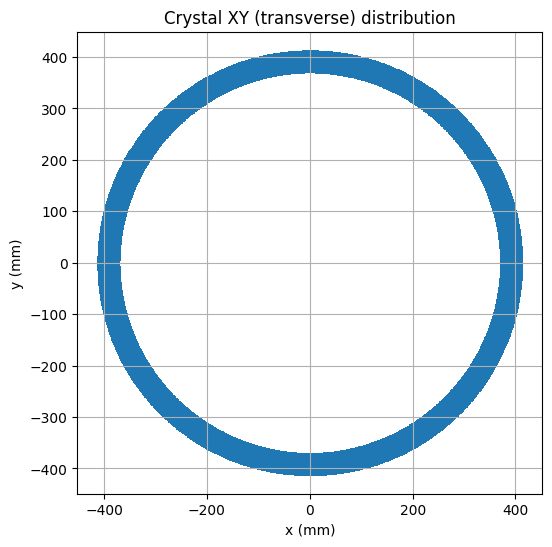

In [161]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(df["x"], df["y"], s=0.2, alpha=0.5)
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.axis("equal")
plt.title("Crystal XY (transverse) distribution")
plt.grid(True)
plt.show()


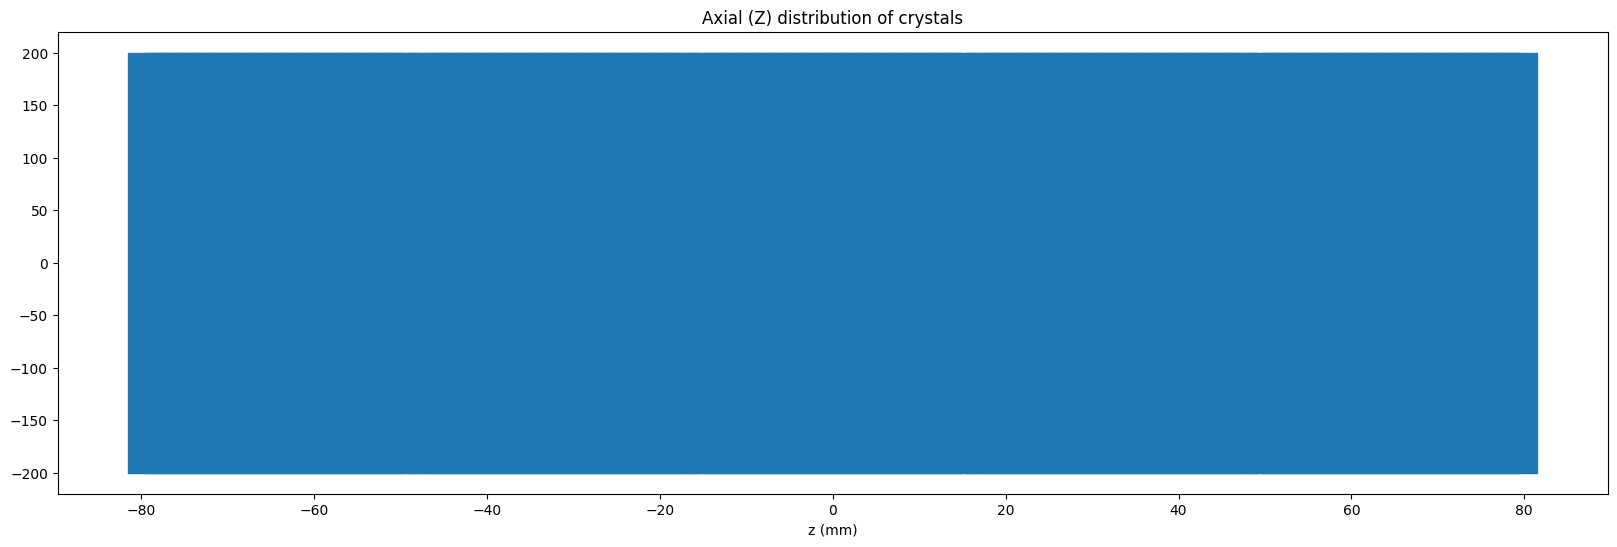

In [162]:
plt.figure(figsize=(20,6))
# axial crystal size = 1mm, plot the span of each crystal
unique_z = np.unique(df["z"])
for z in unique_z:
    plt.fill_betweenx([-200, 200], z - 2, z + 2, color="C0")

plt.xlabel("z (mm)")
plt.title("Axial (Z) distribution of crystals")
#plt.grid(True)
plt.show()
